In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf

## Importing and Preprocessing

In [2]:
# read in the df
links_df = pd.read_csv('links.csv')
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')
tags_df = pd.read_csv('tags.csv')

In [3]:
# original shape of df

print('tags shape', tags_df.shape)

tags shape (3683, 4)


In [4]:
print('links shape', links_df.shape, '\n')
print(links_df.info())
links_df.head()

links shape (9742, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
None


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
print('movies shape', movies_df.shape, '\n')
print(movies_df.info())
movies_df.head()

movies shape (9742, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
print('ratings shape', ratings_df.shape, '\n')
ratings_df.drop(columns='timestamp', inplace=True)
print(ratings_df.info())
ratings_df.head()

ratings shape (100836, 4) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB
None


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [7]:
print('tags shape', tags_df.shape, '\n')
print(tags_df.info())
tags_df.head()

tags shape (3683, 4) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [8]:
# Merge 'movies' and 'ratings' dataframes
df = ratings_df.merge(movies_df, on='movieId', how='left')
df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [9]:
# Check to see if Nans
df.isnull().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
dtype: int64

In [27]:
rating_table = sqldf("""select rating, count(rating)
            from df
            group by rating
            order by count(rating) DESC
            limit 10""")
rating_table

,rating,count(rating)
0,4.0,26818
1,3.0,20047
2,5.0,13211
3,3.5,13136
4,4.5,8551
5,2.0,7551
6,2.5,5550
7,1.0,2811
8,1.5,1791
9,0.5,1370


(Text(0.5, 1.0, 'Rating of Moview'),
 <matplotlib.legend.Legend at 0x1a388784d0>)

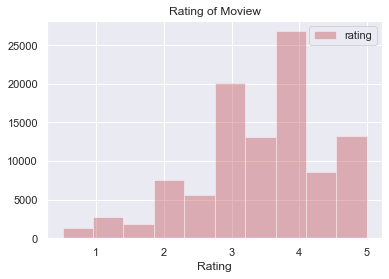

In [60]:
sns.distplot(df['rating'], bins=10, kde=False, color="r", axlabel='Rating', label='rating',)
plt.title("Rating of Moview"), plt.legend()

## Building a Recommendation System

In [ ]:
from pyspark.sql.types import *

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.recommendation import ALS

# split into training and testing sets
(training, test) = df.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)